In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Lambda

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar  3 18:46:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, optimizers, callbacks, applications
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

In [4]:
batch_size = 64

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('drive/My Drive')

In [7]:
!ls

 1628602417763.jpg
'Colab Notebooks'
'Getting started.pdf'
 IMG-bb1327fa43191fc40b07178ad760d4f1-V.jpg
 IMG-fa61f60c88278450511c3dd78d159f3f.jpg
'Ivan Anđelković de.gdoc'
'Ivan Anđelković de.pdf'
 Offer_Document_Ivan_Andelkovic.gdoc
 Offer_Document_Ivan_Andelkovic.pdf
'Project Data Science LW'
'RainmakerSociety_Group Financial Controller_Fitness industry.pdf'
 raw_data
'Teme za ucenje Data Science.gsheet'


In [8]:
# Let's store the location of our data in 2 variables that we can re use later

train_data_dir = 'raw_data/Training'
test_data_dir = 'raw_data/Testing'

In [9]:
train_ds, val_ds = image_dataset_from_directory(
  train_data_dir,
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(255, 255),
  validation_split = 0.2,
  subset="both",
  color_mode = 'rgb',
  batch_size= batch_size)

# We define a second one for the test data

test_ds = image_dataset_from_directory(
  test_data_dir,
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(255, 255),
  color_mode = 'rgb',
  batch_size= batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [11]:

class_names = train_ds.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [12]:
model_main = applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

87910968/87910968 [==============================] - 0s 0us/step


In [13]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [14]:
def initialize_model():
    
    model_v3 = Sequential([
       Lambda(preprocess_input),
        model_main,
        Flatten(),
        Dense(4, activation = 'softmax')
        ])

    return model_v3

In [15]:
model_v3 = initialize_model()

In [16]:
optimizer = optimizers.Adam(learning_rate=0.1)

model_v3.compile(loss = 'categorical_crossentropy',
                  optimizer = "adam",
                  metrics = ['accuracy'])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience = 5, verbose = 2)
history = model_v3.fit(train_ds,
                       validation_data=val_ds,
                      #  callbacks = [es], 
                       epochs = 40 , 
                       batch_size = 64)

Epoch 1/40
72/72 [==============================] - 505s 6s/step - loss: 0.7992 - accuracy: 0.8540 - val_loss: 5.3806 - val_accuracy: 0.3021
Epoch 2/40
72/72 [==============================] - 53s 721ms/step - loss: 0.1937 - accuracy: 0.9418 - val_loss: 1.7620 - val_accuracy: 0.5543
Epoch 3/40
72/72 [==============================] - 50s 682ms/step - loss: 0.2350 - accuracy: 0.9236 - val_loss: 54.5453 - val_accuracy: 0.3748
Epoch 4/40
72/72 [==============================] - 52s 706ms/step - loss: 0.2866 - accuracy: 0.9116 - val_loss: 31.3892 - val_accuracy: 0.3021
Epoch 5/40
72/72 [==============================] - 50s 683ms/step - loss: 0.1112 - accuracy: 0.9611 - val_loss: 0.6372 - val_accuracy: 0.8301
Epoch 6/40
72/72 [==============================] - 52s 705ms/step - loss: 0.0669 - accuracy: 0.9781 - val_loss: 0.1763 - val_accuracy: 0.9580
Epoch 7/40
72/72 [==============================] - 51s 693ms/step - loss: 0.0359 - accuracy: 0.9869 - val_loss: 0.3022 - val_accuracy: 0.9299

In [18]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

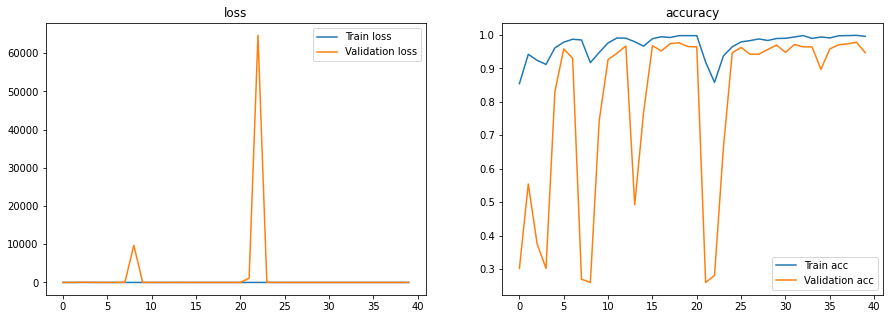

In [19]:
plot_history(history)

In [20]:
model_v3.evaluate(test_ds)

21/21 [==============================] - 137s 4s/step - loss: 0.2360 - accuracy: 0.9588


[0.23597583174705505, 0.9588100910186768]